In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points (<b> equispaced ?</b>), the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
    assert n >= 3 #at least the bounderies + 1 middle point
    assert type(omega) is list
    assert type(bc) is list
    assert len(omega) == 2
    assert len(bc) == 2
    assert omega[0] < omega[-1]
    
    # Get size of each subinterval  (𝑥𝑖,𝑥𝑖+1):
    h = 1./(n-1) 

    # Extract domain boundaries:
    start = omega[0]
    end = omega[-1]
    
    # Evaluate forcing function on grid points:
    x = linspace(start,end,n)
    b = f(x) #rhs
    
    # Using 4𝑡ℎ order FD of 2nd derivative:
    aij2 = 1*ones((n-2,)) # Second Offdiagonal entries
    aij1 = -16*ones((n-1,)) # First Offdiagonal entries
    aii = +30*ones((n,)) # Diagonal entries
    A = (diag(aij2, -2) + diag(aij1, -1) + diag(aii, 0) + diag(aij1, +1) + diag(aij2, +2))
    A /= 12*h**2
    
    # Change first row of the matrix A and rhs
    A[0,:] = 0
    A[0,0] = 1
    b[0] = bc[0]

    # Change last row of the matrix A and rhs
    A[-1,:] = 0
    A[-1,-1] = 1
    b[-1] = bc[-1]
    
    return A, b

Call the function using:

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

print(A)

[[ 1.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [-1.30680e+04  2.45025e+04 -1.30680e+04 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 8.16750e+02 -1.30680e+04  2.45025e+04 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 ...
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  2.45025e+04 -1.30680e+04
   8.16750e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ... -1.30680e+04  2.45025e+04
  -1.30680e+04]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   1.00000e+00]]


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)#lower triangular
    return L, L.transpose()

HT, H = cholesky(A)#upper triangular

<ipython-input-5-adb1c11b8647>:5: RuntimeWarning: invalid value encountered in sqrt
  A[k,k] = sqrt(A[k,k])


Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [7]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

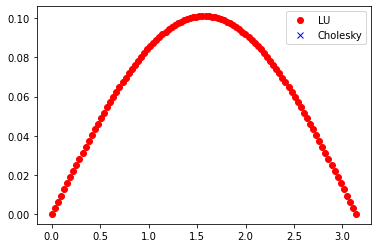

In [8]:
# Using LU
y = L_solve(L,b)
u_LU = U_solve(U,y)

# Using Cholesky
w = L_solve(HT,b)
u_Ch = U_solve(H,w)

x = linspace(omega[0],omega[-1],n)
_ = plot(x,u_LU,'ro', label='LU')
_ = plot(x,u_Ch,'bx', label='Cholesky')
_ = legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Let's first try with n=33:

<ipython-input-5-adb1c11b8647>:5: RuntimeWarning: invalid value encountered in sqrt
  A[k,k] = sqrt(A[k,k])


nan
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.36533333e+03  2.56000000e+03 -1.36533333e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.53333333e+01 -1.36533333e+03  2.56000000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.56000000e+03
  -1.36533333e+03  8.53333333e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.36533333e+03
   2.56000000e+03 -1.36533333e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
[0.         0.03027344 0.05859375 0.08496094 0.109375   0.13183594
 0.15234375 0.17089844 0.1875     0.20214844 0.21484375 0.22558594
 0.234375   0.24121094 0.24609375 0.24902344 0.25       0.24902344
 0.24609375 0.24121094 0.234375   0.22558594 0.21484375 0.20214844
 0.1875     0.17089844 0.15234375 0.13183594 0.109375   0.08496094
 0.05859375 0.03027344 0.

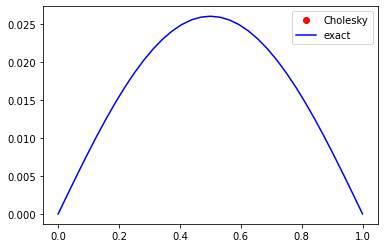

In [9]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]

A, b = finDif(omega, f, 33, bc)
HT, H = cholesky(A)
y = L_solve(HT,b)
u = U_solve(H,y)
x = linspace(omega[0],omega[-1],33)
error = max(abs(u_ex(x)-u))
print(error)


#x = linspace(omega[0],omega[-1],n)
_ = plot(x,u,'ro', label='Cholesky')
_ = plot(x,u_ex(x), 'b', label='exact')
_ = legend()

print(A)
print(b)


Then with $ n \in (3, 300)$:

<ipython-input-5-adb1c11b8647>:5: RuntimeWarning: invalid value encountered in sqrt
  A[k,k] = sqrt(A[k,k])


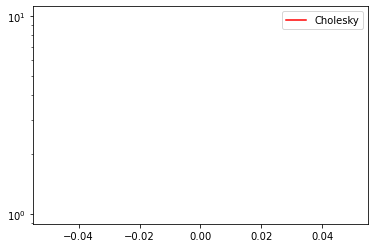

In [10]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]

N = range(3, 301)
errors = zeros(len(N))

for n in N:
    A, b = finDif(omega, f, n, bc)
    HT, H = cholesky(A)
    y = L_solve(HT,b)
    u = U_solve(H,y)
    x = linspace(omega[0],omega[-1],n)
    errors[n-3] = max(abs(u_ex(x)-u))

#x = linspace(N[0],N[-1],len(N))
_ = semilogy(N,errors,'r', label='Cholesky')
_ = legend()

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [11]:
def condNumb(A):
    pass #TODO
    return condNu

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [12]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    pass #TODO

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [13]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [14]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [15]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [16]:
#TODO